In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import f1_score
from collections import defaultdict
import numpy as np
import transformers
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torch
import sys

In [92]:
class TweetsDataset(Dataset):
    def __init__(self, tweets, labels, tokenizer):
        self.tweets = tweets; 
        self. labels = labels;
        self.tokenizer = tokenizer
        self.max_len = 512
    def __len__(self):
        return len(self.tweets)
    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens = True,
            max_length=self.max_len,
            truncation = True,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'tweet': tweet, 
            'input_ids': encoding['input_ids'].long().flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }
    
def create_data_loader(df, tokenizer, batch_size = 16):
    ds = TweetsDataset(
        tweets=df.tweets.to_numpy(),
        labels=df.labels.to_numpy(),
        tokenizer=tokenizer
    )
    return DataLoader(
        ds,
        batch_size=batch_size
    )
    
def test(model, test_data_loader, device, test_len):
    model = model.eval()
    correct_predictions = 0
    losses = []
    with torch.no_grad():
        for d in test_data_loader:
            loss, logits = model(
                input_ids = d["in put_ids"].to(device),
                attention_mask = d["attention_mask"].to(device),
                labels = F.one_hot(d["labels"].to(device), num_classes=4).float(),
                return_dict=False
            )
            logits = logits.detach().cpu().numpy()
            labels_ids = d['labels'].cpu().flatten().numpy()
            preds = np.argmax(logits, axis=1).flatten()
            targ = d['labels'].numpy()
            correct_predictions += np.sum(preds==targ)
            losses.append(loss.item())
    return correct_predictions / test_len, np.mean(losses)


def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    for i,d in tqdm(enumerate(data_loader)):
        loss, logits = model(
            input_ids=d["input_ids"].to(device),
            attention_mask=d["attention_mask"].to(device),
            labels=F.one_hot(d['labels'].to(device), num_classes=4).float(),
            return_dict=False
        )
        logits = logits.detach().cpu().numpy()
        label_ids = d['labels'].cpu().flatten().numpy()
        preds = np.argmax(logits, axis=1).flatten()
        targ = d['labels'].numpy()
        correct_predictions += np.sum(preds==targ)
        losses.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions / n_examples, np.mean(losses)

def train_model(model, epochs, train_data_loader, optimizer, device, scheduler, train_len):
    for epoch in range(epochs):
        train_acc, train_loss = train_epoch(model, train_data_loader, optimizer, device, scheduler, train_len)
        print(f"Train acc: {train_acc}, train_loss: {train_}")
         

def tune_params(learning_rate, num_epochs, batch_size, model_name, filename):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    results = pd.DataFrame({})
    tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
    df_train = pd.read_csv("../../../data/procesed.csv")
    df_test = pd.read_csv("../../../data/procesed_test.csv")
    for epochs in num_epochs:
        total_steps = len(df_train) * epochs
        for bs in batch_size:
            train_data_loader = create_data_loader(df_train, tokenizer, bs)
            test_data_loader = create_data_loader(df_test, tokenizer, bs)
            for lr in learning_rate:
                print(f'Training with params: {epochs} epochs, {batch_size} batch_size, {lr} learning_rate')
                model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4).to(device)
                optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
                scheduler = transformers.get_linear_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps = 0,
                    num_training_steps = total_steps
                )
                train_model(model, epochs, train_data_loader, optimizer, device, scheduler, len(df_train))
                test_acc, test_loss = test(model, test_data_loader, device, len(df_test))
                results = pd.concat([results, pd.DataFrame({
                    "epochs": epochs,
                    "learning_rate": lr,
                    "batch_size": bs,
                    "accuracy": test_acc,
                    "loss": test_loss
                }, index=[0])]).reset_index(drop=True)
    results.to_csv(filename)

In [93]:
tune_params(learning_rate=[1e-4,5e-5, 2e-5,1e-5], num_epochs=[6,8,10],batch_size=[4, 8], model_name="dccuchile/bert-base-spanish-wwm-cased", filename="tuning_berto.csv")

Training with params: 6 epochs, [4, 8] batch_size, 0.0001 learning_rate


Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

KeyboardInterrupt: 

In [47]:
berto = pd.read_csv("./tuning_berto.csv", index_col = 0)

In [64]:
berto

,learning_rate,batch_size,accuracy,loss
epochs,,,,
6,0.00010,4,0.4,0.606775
6,0.00005,4,0.4,0.725858
6,0.00002,4,0.4,0.602464
6,0.00001,4,0.4,0.597706
6,0.00010,8,0.4,0.681393
6,0.00005,8,0.4,0.615842
6,0.00002,8,0.4,0.602084
6,0.00001,8,0.4,0.557218
8,0.00010,4,0.4,0.609470


learning_rate
0.00001    AxesSubplot(0.125,0.11;0.775x0.77)
0.00002    AxesSubplot(0.125,0.11;0.775x0.77)
0.00005    AxesSubplot(0.125,0.11;0.775x0.77)
0.00010    AxesSubplot(0.125,0.11;0.775x0.77)
Name: loss, dtype: object

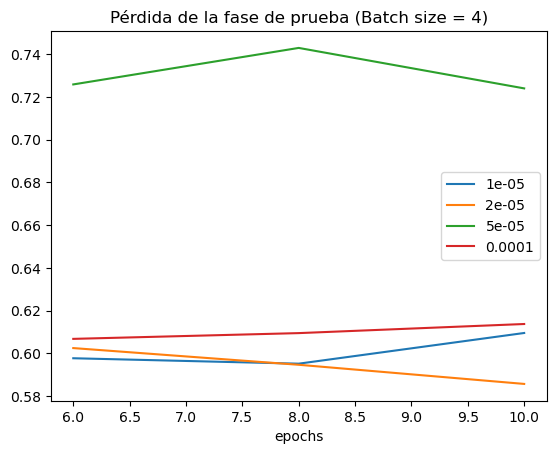

In [73]:
#berto.set_index(["epochs"], inplace=True)
berto[berto["batch_size"] == 4].groupby(["learning_rate"])["loss"].plot(legend="true", title = "Pérdida de la fase de prueba (Batch size = 4)")

learning_rate
0.00001    AxesSubplot(0.125,0.11;0.775x0.77)
0.00002    AxesSubplot(0.125,0.11;0.775x0.77)
0.00005    AxesSubplot(0.125,0.11;0.775x0.77)
0.00010    AxesSubplot(0.125,0.11;0.775x0.77)
Name: loss, dtype: object

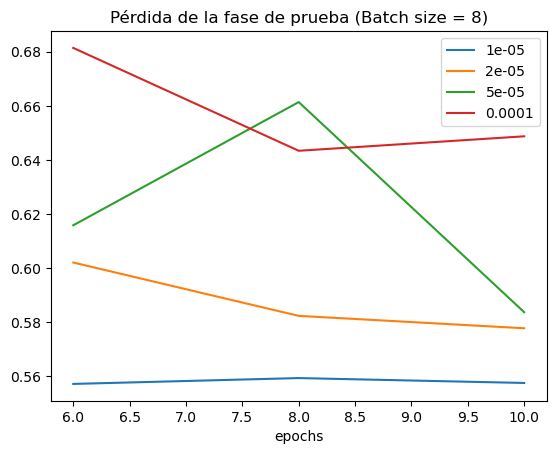

In [74]:
berto[berto["batch_size"] == 8].groupby(["learning_rate"])["loss"].plot(legend="true", title = "Pérdida de la fase de prueba (Batch size = 8)")

learning_rate
0.00001    AxesSubplot(0.125,0.11;0.775x0.77)
0.00002    AxesSubplot(0.125,0.11;0.775x0.77)
0.00005    AxesSubplot(0.125,0.11;0.775x0.77)
0.00010    AxesSubplot(0.125,0.11;0.775x0.77)
Name: accuracy, dtype: object

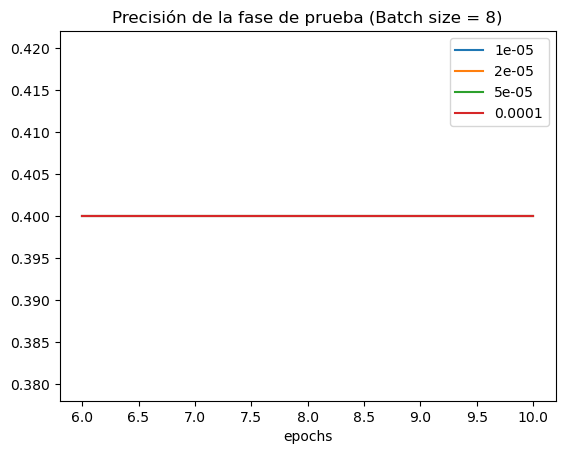

In [77]:
berto[berto["batch_size"] == 8].groupby(["learning_rate"])["accuracy"].plot(legend="true", title = "Precisión de la fase de prueba (Batch size = 8)")

learning_rate
0.00001    AxesSubplot(0.125,0.11;0.775x0.77)
0.00002    AxesSubplot(0.125,0.11;0.775x0.77)
0.00005    AxesSubplot(0.125,0.11;0.775x0.77)
0.00010    AxesSubplot(0.125,0.11;0.775x0.77)
Name: accuracy, dtype: object

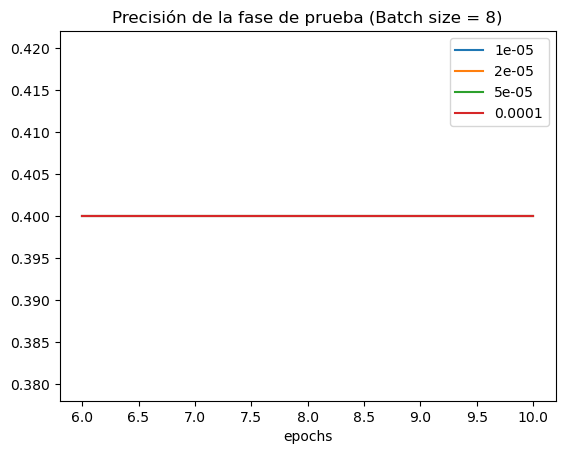

In [78]:
berto[berto["batch_size"] == 4].groupby(["learning_rate"])["accuracy"].plot(legend="true", title = "Precisión de la fase de prueba (Batch size = 8)")

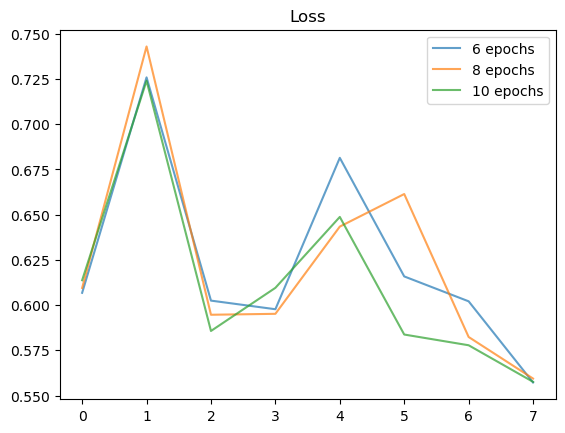

In [52]:
plt.plot(berto[berto["epochs"] == 6]["loss"].reset_index(drop = True), label="6 epochs", alpha=0.7)
plt.plot(berto[berto["epochs"] == 8]["loss"].reset_index(drop = True), label="8 epochs", alpha=0.7)
plt.plot(berto[berto["epochs"] == 10]["loss"].reset_index(drop = True), label="10 epochs", alpha=0.7)
plt.title("Loss")
plt.legend()